# Load the GearBox data

# Load the GearBox data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


In [2]:
import load_data

pth1 = 'data/ring'
pth2 = 'data/negative'
window_len = 200  # How many window_len as 1 feature point 
inference_data_point = 5 # This value should be considered the MCU rom size. 5*300*10*2 = 30000 float points

broken_df_train, broken_df_test  = load_data.create_test_train_df_fromRaw(pth1 , 1, 
                                    inference_data_point, window_len, (load_data.addCol_load, load_data.addCol_fault))        
healthy_df_train, healthy_df_test = load_data.create_test_train_df_fromRaw(pth2 , 0, 
                                    inference_data_point, window_len, (load_data.addCol_load, load_data.addCol_fault))

['data/ring\\ad_output_wing_cy.txt']
20200
['data/negative\\ad_output_negative_1.txt']
20200


In [3]:
#broken_df_test
#broken_df_train
#broken_df_train.shape
#len(broken_df_train)

# Feature Process

# Feature Process

In [4]:
import feature_process
Data_healthy, Lable_healthy = feature_process.gesture_map_autoencoder(healthy_df_train, 0, window_len, 3, 3)#200 =>0.87% #300 => 90%~92%(batch_size=256), #400 => 90%~92%(batch_size=128), #500 => 93%(batch_size=64)
Data_broken, Lable_broken = feature_process.gesture_map_autoencoder(broken_df_train, 1, window_len, 3, 3)
print("feature array shape of healthy point: {}, {}".format(Data_healthy.shape, Lable_healthy.shape))
print("feature array shape of broken point: {}, {}".format(Data_broken.shape, Lable_broken.shape))

(96, 200, 3, 1)
(19200, 5)
expand dim 0
(96, 200, 3, 1)
(96, 200, 3, 1)
(19200, 5)
expand dim 0
(96, 200, 3, 1)
feature array shape of healthy point: (96, 200, 3, 1), (96,)
feature array shape of broken point: (96, 200, 3, 1), (96,)


In [5]:
#tf.expand_dims(Data_broken,0)

In [6]:
# Create the random 80% train and 20% test
train_data, test_data, train_labels, test_labels = feature_process.concatenate_data(Data_healthy,Data_broken,Lable_healthy,Lable_broken, 0.1, 21)
print("train data shape: {}, {}".format(train_data.shape, train_labels.shape))
print("test data shape: {}, {}".format(test_data.shape, test_labels.shape))
#print(test_data)
# save the max&min val
max_val = tf.reduce_max(train_data)
min_val = tf.reduce_min(train_data)

train data shape: (172, 200, 3, 1), (172,)
test data shape: (20, 200, 3, 1), (20,)


# Autoencoder

## Autoencoder data prepare
- Need to normalize the data
- Need to sperate the data into normal and anomalous set

In [7]:
# normalize
train_data, test_data = feature_process.normalize_data_maxmin(train_data, test_data)
print(type(train_data))

# sperate to True & False for Autoencoder
normal_train_data, anomalous_train_data = feature_process.normal_anomalous_distb(train_data, train_labels)
normal_test_data, anomalous_test_data = feature_process.normal_anomalous_distb(test_data, test_labels)
print("anomalous train data set: {}".format(anomalous_train_data.shape))
print("normal train data set: {}".format(normal_train_data.shape))

tf.Tensor(1644.0, shape=(), dtype=float64) tf.Tensor(-377.0, shape=(), dtype=float64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
anomalous train data set: (84, 200, 3, 1)
normal train data set: (88, 200, 3, 1)


In [8]:
normal_train_data[0].shape

TensorShape([200, 3, 1])

In [9]:
normal_train_data.shape

TensorShape([88, 200, 3, 1])

## Autoencoder Training

In [10]:
def create_autoencoder(sample_shape):
    #sample_shape = normal_train_data[0].shape
    
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=sample_shape),
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2), padding="same"),
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2), padding="same"),

        # Decoder
        layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"),
        layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"),
        layers.Conv2D(1, (1, 2), activation="relu", padding="valid"),
        layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")
    ])
    
    # Display model
    model.summary()
    model.compile(optimizer='adam', loss='mae')
    return model
Autoen_model = create_autoencoder(normal_train_data[0].shape)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 3, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 2, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 2, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 1, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 100, 2, 32)        9248      
 anspose)                                                        
                                                        

### Train model (note Y labels are same as inputs, X)
def train_autoencoder(m_epochs, m_batch_size, normal_train_data, normal_test_data, ):
    history = Autoen_model.fit(normal_train_data, normal_train_data,
                               epochs=m_epochs,
                               batch_size=m_batch_size,
                               validation_data=(normal_test_data, normal_test_data), 
                               shuffle=True)
    return history
history = train_autoencoder(300, 128, normal_train_data, normal_test_data)

In [11]:
# Train model (note Y labels are same as inputs, X)
def train_autoencoder(m_epochs, m_batch_size, normal_train_data, normal_test_data, ):
    history = Autoen_model.fit(normal_train_data, normal_train_data,
                               epochs=m_epochs,
                               batch_size=m_batch_size,
                               validation_data=(normal_test_data, normal_test_data), 
                               shuffle=True)
    return history
history = train_autoencoder(300, 128, normal_train_data, normal_test_data)

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 0.2843 - val_loss: 0.2842
Epoch 2/300
1/1 [==============================] - 0s 148ms/step - loss: 0.2842 - val_loss: 0.2837
Epoch 3/300
1/1 [==============================] - 0s 157ms/step - loss: 0.2837 - val_loss: 0.2831
Epoch 4/300
1/1 [==============================] - 0s 161ms/step - loss: 0.2831 - val_loss: 0.2825
Epoch 5/300
1/1 [==============================] - 0s 148ms/step - loss: 0.2825 - val_loss: 0.2818
Epoch 6/300
1/1 [==============================] - 0s 138ms/step - loss: 0.2818 - val_loss: 0.2806
Epoch 7/300
1/1 [==============================] - 0s 143ms/step - loss: 0.2806 - val_loss: 0.2787
Epoch 8/300
1/1 [==============================] - 0s 147ms/step - loss: 0.2787 - val_loss: 0.2763
Epoch 9/300
1/1 [==============================] - 0s 156ms/step - loss: 0.2763 - val_loss: 0.2735
Epoch 10/300
1/1 [==============================] - 0s 174ms/step - loss: 0.2735 - val_loss: 0.2701
Epoch 11/300

### Show the loss and decide threshold

## Test Result

3/3 [==============================] - 0s 17ms/step


C:\Users\stanly-lin\AppData\Local\Temp\ipykernel_13960\4250119270.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  axesSub = sns.lineplot(data = history_autoen.history["loss"], ci = None, label="Training Loss", ax=ax[0])
C:\Users\stanly-lin\AppData\Local\Temp\ipykernel_13960\4250119270.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  axesSub = sns.lineplot(data = history_autoen.history["val_loss"], ci = None, label="Validation Loss", ax=ax[0])


(88, 600, 1)
(88, 600, 1)
train_loss.shape: (88, 600)
3/3 [==============================] - 0s 16ms/step


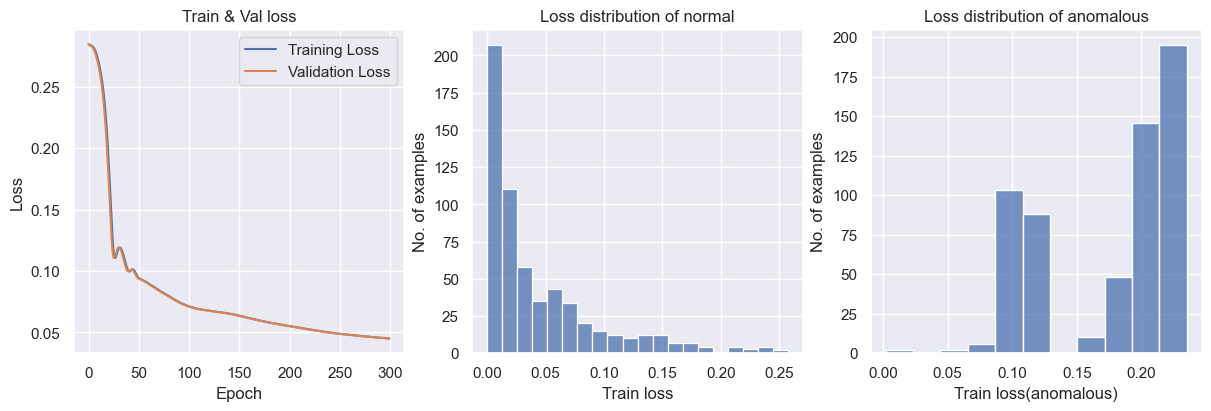

Threshold:  0.096794516


In [65]:
def result_autoencoder(model_autoen, history_autoen, normal_data, anomalous_data):

    sns.set(style="darkgrid")  # darkgrid, whitegrid, dark, white, ticks
    fig, ax =plt.subplots(1,3,constrained_layout=True, figsize=(12, 4))
    
    axesSub = sns.lineplot(data = history_autoen.history["loss"], ci = None, label="Training Loss", ax=ax[0])
    axesSub = sns.lineplot(data = history_autoen.history["val_loss"], ci = None, label="Validation Loss", ax=ax[0])
    axesSub.set_xlabel('Epoch')
    axesSub.set_ylabel('Loss')
    axesSub.set_title('Train & Val loss')
    
    # For finding threshold to fault detection, histogram, of train loss and test loss was plotted
    reconstructions = model_autoen.predict(normal_data)
    xx = np.reshape(reconstructions, (88,600,1))
    xx_data = np.reshape(normal_data, (88,600,1))
    print(xx.shape)#check shape
    print(xx_data.shape)#check shape
    train_loss = tf.keras.losses.mae(xx, xx_data)
    train_loss = np.array(train_loss) #convert to np.array
    print('train_loss.shape: ', end='')#check shape
    print(train_loss.shape)#check shape
    #print(train_loss[1,1])#check shape
    #print(train_loss[32,1])#check shape
  
    
    axesSub = sns.histplot(data=(train_loss[0]), ax=ax[1])
    axesSub.set_xlabel('Train loss')
    axesSub.set_ylabel('No. of examples')
    axesSub.set_title('Loss distribution of normal')
    
    reconstructions = model_autoen.predict(anomalous_data)
    yy = np.reshape(reconstructions, (84,600,1))
    yy_data = np.reshape(anomalous_data, (84,600,1))
    test_loss = tf.keras.losses.mae(yy, yy_data)
    #test_loss = tf.keras.losses.mse(reconstructions, anomalous_data)
    test_loss = np.array(test_loss) #convert to np.array

    axesSub = sns.histplot(data=(test_loss[0]), ax=ax[2])
    axesSub.set_xlabel('Train loss(anomalous)')
    axesSub.set_ylabel('No. of examples')
    axesSub.set_title('Loss distribution of anomalous')
    
    plt.show()
    
    # threshold for fault detection based on model error
    threshold = np.mean(train_loss) + np.std(train_loss)
    print("Threshold: ", threshold)
    return threshold

threshold = result_autoencoder(Autoen_model, history, normal_train_data, anomalous_train_data)

## Show MCU Inference Result first
- This dataset is for MCU inference latter, and we use PC python to inference first.
- The `Accuracy` value should be almost same as MCU result latter.  

In [108]:
def predict(model, data, threshold):
    reconstructions = model(data)
    
    onedim_recons = np.reshape(reconstructions, (reconstructions.shape[0],600,1))
    onedim_data = np.reshape(data, (data.shape[0],600,1))
    print('onedim_recons=', end='')
    print(onedim_recons.shape)
    print('onedim_data=', end='')
    print(onedim_data.shape)
    
    loss = tf.keras.losses.mae(onedim_recons, onedim_data)
    #loss = tf.keras.losses.mse(reconstructions, data)  
    print('loss=', end='')
    print(loss.shape)
    print('threshold=', end='')
    print(threshold)
    ret_label = np.zeros([data.shape[0],1])
    for i in range(0, data.shape[0]):
        ret = tf.math.less(np.mean(loss), threshold*)
        if (ret==True):
            ret_label[i] =  (int)(1)
        else:
            ret_label[i] = (int)(0)
    return ret_label
    #return tf.math.less(np.mean(loss), threshold)

def print_stats(predictions, labels):
    print(predictions)
    print(labels)

    #labels_1d = np.reshape(labels, (labels.shape[0]*600,1))
    #predictions_1d = np.reshape(predictions, (predictions.shape[0]*600,1))
    #
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    
# accuracy
print("Test Data number: {}".format(test_data.shape[0]))
preds = predict(Autoen_model, test_data, threshold)
print('preds.val=', end='')
#print(preds.shape)
#print(preds)
print_stats(preds, test_labels)

print("Train Data number: {}".format(train_data.shape[0]))
preds = predict(Autoen_model, train_data, threshold)
print_stats(preds, train_labels)

# accuracy for 

Test Data number: 20
onedim_recons=(20, 600, 1)
onedim_data=(20, 600, 1)
loss=(20, 600)
threshold=0.096794516
preds.val=[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.]
Accuracy = 0.4
Precision = 0.4
Recall = 1.0
Train Data number: 172
onedim_recons=(172, 600, 1)
onedim_data=(172, 600, 1)
loss=(172, 600)
threshold=0.096794516
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

In [94]:
# accuracy for MCU inference data

# calculate feature
Data_healthy_test, Lable_healthy_test = feature_process.window_feature_autoencoder(healthy_df_test, 0, window_len, 4, 16)#200 =>0.87% #300 => 90%~92%(batch_size=256), #400 => 90%~92%(batch_size=128), #500 => 93%(batch_size=64)
Data_broken_test, Lable_broken_test = feature_process.window_feature_autoencoder(broken_df_test, 1, window_len, 4, 16)
print("feature array shape of test healthy point: {}, {}".format(Data_healthy_test.shape, Lable_healthy_test.shape))
print("feature array shape of test broken point: {}, {}".format(Data_broken_test.shape, Lable_broken_test.shape))
inference_data = np.concatenate([Data_healthy_test, Data_broken_test], axis =0)
inference_label = np.concatenate([Lable_healthy_test, Lable_broken_test], axis =0)

# normalize
# min_val = tf.reduce_min(inference_data)
# max_val = tf.reduce_max(inference_data)
print(max_val, min_val)
inference_data = (inference_data - min_val) / (max_val - min_val)
inference_data = tf.cast(inference_data, tf.float32)

print("Test Data number: {}".format(inference_data.shape[0]))
preds = predict(Autoen_model, inference_data, threshold)
print_stats(preds, inference_label)

feature array shape of test healthy point: (5, 16), (5,)
feature array shape of test broken point: (5, 16), (5,)
tf.Tensor(1644.0, shape=(), dtype=float64) tf.Tensor(-377.0, shape=(), dtype=float64)
Test Data number: 10


ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 200, 3, 1), found shape=(10, 16)

# TensorFlow Lite Conversion

In [ ]:
# If we're happy with the performance, save the model
ori_model = Autoen_model
keras_model_name = 'autoencoder'

tf.saved_model.save(ori_model, keras_model_name)

In [ ]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(ori_model)
tflite_model = converter.convert()
open(keras_model_name + '.tflite', 'wb').write(tflite_model)

In [ ]:
def tflite_to_tflu(models_path, c_model_name, keras_model_name, threshold, maxV, minV):
    
    tflite_name = (keras_model_name + '.tflite')
    my_f_name = (os.path.join(models_path, c_model_name) + '.cc')
    ! python tflite_to_tflu_para.py --tflite_path $tflite_name --output_path $my_f_name --window_size_sample $window_len --max_val_train $maxV --min_val_train $minV --threshold_val $threshold

models_path = 'model'
c_model_name = r'Gearbox_fault_' + keras_model_name    
tflite_to_tflu(models_path, c_model_name, keras_model_name, threshold, max_val.numpy(), min_val.numpy())    

# Convert the test data to C code
- This data set is after preprocessed.
- Just used to make sure the model is ok.

In [ ]:
import c_writer
how_many_test = test_data.shape[0]

Xtest = test_data.numpy()[:how_many_test,:]  ##transfer to nparray
#print(c_writer.create_array(Xtest,"float","X_test"))
Xtest_str = c_writer.create_array(Xtest,"float","X_test")

ytest = test_labels[:how_many_test].astype(int)
ytest_str = c_writer.create_array(ytest,"uint8_t","y_test")

test_d = Xtest_str + ytest_str

header_test_d = c_writer.create_header(test_d, "gearbox_test_data")
with open( os.path.join("data", "gearbox_test_data") + '.h', 'w') as file:
    file.write(header_test_d)

# Convert the raw data to C code
- This data is raw data, for edge device to inference.
- It is a more realistic case.

In [ ]:
import c_writer
def save_test_data_inC(data_X , label_y):
  
    Xtest = data_X
    Xtest_str = c_writer.create_array(Xtest,"float","X_test", 1)
    
    ytest = label_y.astype(int)
    ytest_str = c_writer.create_array(ytest,"uint8_t","y_test")
    
    test_d = Xtest_str + ytest_str
    
    header_test_d = c_writer.create_header(test_d, "gearbox_raw_test_data")
    with open( os.path.join("data", "gearbox_raw_test_data") + '.h', 'w') as file:
        file.write(header_test_d)

raw_data = np.concatenate([healthy_df_test, broken_df_test], axis =0)
raw_label = np.concatenate([Lable_healthy_test, Lable_broken_test], axis =0)
print("The raw data size is: {}".format(len(raw_data)))
print("The raw label size is: {}".format(len(raw_label)))
save_test_data_inC(raw_data[:,0:4], raw_label)        